# Imports

In [1]:
import yaml
import warnings
from utils import *
warnings.filterwarnings("ignore")

## Loading the configurations
We first load the configuration of each experiment. The default parameters are given in `default_config`, while the parameters `target_column`, `other_columns`, `groups_column`, `path` and `type` must first be present in the config file.

In [48]:
# read yaml configurations for experiments
with open('experiments_config.yaml') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

configs = {v['id']: v for v in configs['experiments']}

# default parameters for experiments
default_config = {
    'n_iterations': 5,
    'test_size': 0.2,
    'split_by_env': True,
    'model_type': 'all',
    'model_args': {},
    'mu_limits': (0.1, 0.4),
    'controlled_mus': 5
}

## Running the experiments
Now we turn to running the actual experiments.
The code performs the following steps:  
- Loading the configuration for the current experiment
- Loading the dataset from parameters `path`
- Performing `n_iterations` bootstrapping of the RMSE estimators
- if `controlled_mus` is not None (i.e, its an integer), then tests all mu_test values between mu_train and 0.4. Otherwise, randomly draws mu_train, mu_test between 0.1 and 0.4. 
- Computes the various rMSE metrics and produces the plots

Running experiment: 0, from ./Datasets/popular2.sav
# samples: 2000, # features: 15, # environments: 100


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


Running experiment: 1, from ./Datasets/dataset1reshape.csv
# samples: 348, # features: 10, # environments: 6


100%|██████████| 25/25 [00:07<00:00,  3.35it/s]


Running experiment: 2, from ./Datasets/dataset2reshape.csv
# samples: 200, # features: 33, # environments: 4


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Running experiment: 3, from ./Datasets/dataset3reshape.csv
# samples: 360, # features: 12, # environments: 6


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Running experiment: 4, from ./Datasets/dataset4reshape.csv
# samples: 480, # features: 17, # environments: 6


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Running experiment: 5, from ./Datasets/dataset5reshape.csv
# samples: 500, # features: 22, # environments: 5


100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


Running experiment: 6, from ./Datasets/dataset6reshape.csv
# samples: 480, # features: 62, # environments: 4


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


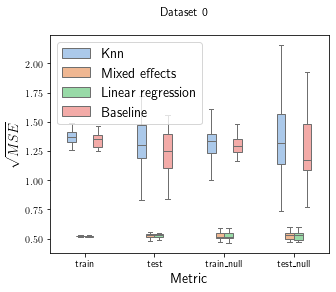

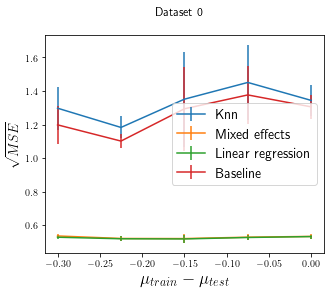

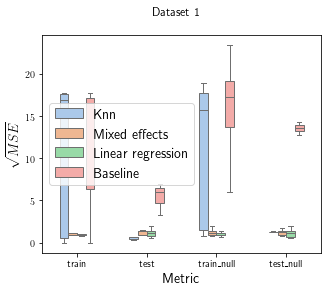

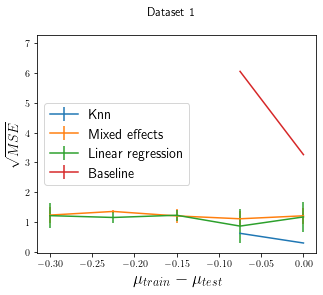

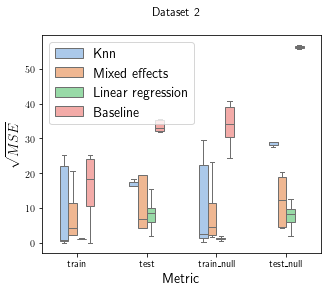

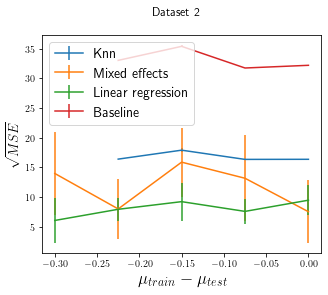

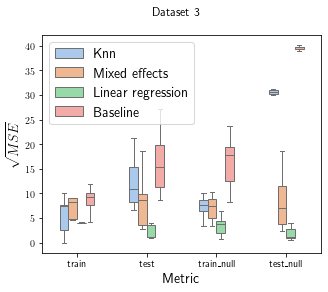

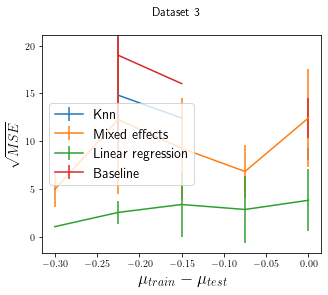

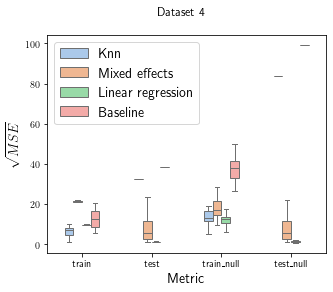

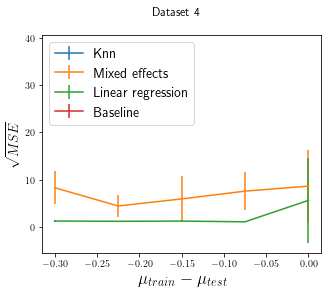

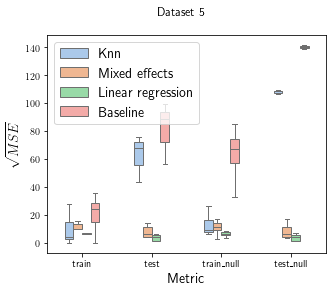

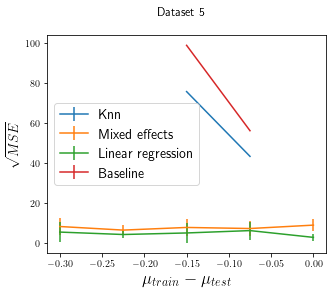

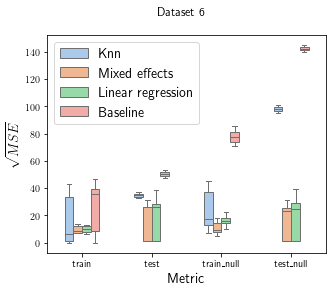

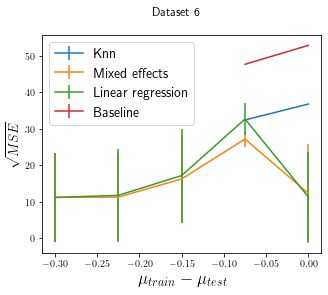

In [49]:
results = {}
for k, exp in configs.items():
    current_config = default_config.copy()
    current_config.update(exp)
    
    path_to_data = current_config.get('path')
    data_type = current_config.get('type')
    if data_type == 'sav':
        df = pd.read_spss(path_to_data)
    elif data_type == 'csv':
        df = pd.read_csv(path_to_data)
    else:
        raise ValueError(f"Unknown data type: {data_type}")
    
    del current_config['id']
    del current_config['path']
    del current_config['type']
    
    print(f"Running experiment: {k}, from {path_to_data}")
    print(f"# samples: {df.shape[0]}, # features: {df.shape[1]}, # environments: {df[current_config.get('groups_column')].nunique()}")
    df[current_config.get('groups_column')] = df[current_config.get('groups_column')].astype('category')
    metrics, train_probs, test_probs = bootstrapping(df, **current_config)

    mean_metrics, std_metrics = compute_mean_std_metrics(metrics)
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
    error_plot(metrics, ax1)
    plt.suptitle(f"Dataset {k}")
    
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
    mu_diff_vs_rmse_plot(metrics, train_probs, test_probs, ax2)
    plt.suptitle(f"Dataset {k}")

    results[k] = {
        'mean_metrics': mean_metrics,
        'std_metrics': std_metrics,
        'figures': (fig1, fig2),
        'axes': (ax1, ax2)
    }

## Further finetuning of the plots and saving them to files

### Aggregate results plot

In [47]:
# mean results for all experiments
sum_mean_results = defaultdict(lambda: defaultdict(float))
for k, v in results.items():
    for m, val in v['mean_metrics'].items():
        sum_mean_results['train_rmse'][m] += val['train_rmse']
        sum_mean_results['test_rmse'][m] += val['test_rmse']
    
for m in sum_mean_results.keys():
    for k in sum_mean_results[m].keys():
        sum_mean_results[m][k] /= len(results)

# std results for all experiments
sum_std_results = defaultdict(lambda: defaultdict(float))
for k, v in results.items():
    for m, val in v['std_metrics'].items():
        sum_std_results['train_rmse'][m] += val['train_rmse']
        sum_std_results['test_rmse'][m] += val['test_rmse']

for m in sum_std_results.keys():
    for k in sum_std_results[m].keys():
        sum_std_results[m][k] /= len(results)


fig3, ax3 = plt.subplots(1, 1, figsize=(10, 7))
sum_results_df = pd.DataFrame(sum_mean_results)
sum_results_df.plot(kind='bar', ax=ax3, yerr=pd.DataFrame(sum_std_results), capsize=5)
plt.suptitle("Mean RMSE for all experiments", fontsize=24)

plt.legend(fontsize=14)
plt.xticks(rotation=45, ticks=ax3.get_xticks(), labels=[i.replace('_', ' ').capitalize() for i in sum_results_df.index], fontsize=22)
plt.yticks(fontsize=18)
plt.tight_layout()
if not os.path.exists('paper/figures'):
    os.makedirs('paper/figures')
fig3.savefig('paper/figures/mean_rmse.pdf')


### Individual results plots

In [46]:
# save all plots
for k, v in results.items():
    # add title
    v['figures'][0].suptitle(f"Dataset {k+1} - Error plot", fontsize=24)
    v['figures'][1].suptitle(f"Dataset {k+1} - RMSE and Distribution Divergence", fontsize=24)

    # set x axis tick labels font size
    for i, ax in enumerate(v['axes']):
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 0:
            ax.set_xlabel("Data Split", fontsize=22)
        else:    
            ax.set_xlabel(r"$\Delta(\mu)$", fontsize=22)
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)
        
    v['figures'][0].savefig(f"paper/figures/{k+1}_error_plot.pdf")
    v['figures'][1].savefig(f"paper/figures/{k+1}_mu_diff_vs_rmse_plot.pdf")